**TODO**
- Should probably use context channel in state https://langchain-ai.github.io/langgraph/how-tos/state-context-key/
- Scratch pad for data, give ID and allow the LLM to reference - could this be a bunch of different dfs?
- Should sql info be sent back in html? Is this the best format for an llm having been trained on html?
- May need an llm to help format vega charts, spot errors etc
- Create temp dataset, couple with vega spec

**ISSUES**
- Spending a lot of time generating a vega spec + plus wasting a lot of tokens
- Consider vega-fusion and uuid-named view in duckdb, ask the llm to generate the vega spec without data https://vegafusion.io/duckdb.html#access-duckdb-tables
- Can we get metadata about the results to generate the vega spec
- How can we get an llm to analyse trends, when the only thing it can work with is text?
- Struggles with time series analysis.
- Need to be able to catch a follow up - would you like me to continue type message


In [1]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [2]:
QUERY_ROW_LIMIT = 200

Model

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0, streaming=True)

Database

In [4]:
import pandas as pd
from pandas import DataFrame
import duckdb
from duckdb import DuckDBPyConnection


def build_db(data: dict[str, DataFrame]) -> DuckDBPyConnection:
    """Create an in-memory duckdb database from on or more pandas dataframes.

    Dict format:

        {"table_name": DataFrame}

    Args:
        data: Dict in the form {"table_name": DataFrame}.

    Returns:
        Connection to the duckdb database.
    """
    connection = duckdb.connect(":memory:")

    for table_name, dataframe in data.items():
        connection.register(table_name, dataframe)

    return connection

Tools

In [5]:
from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig
import altair as alt


@tool(parse_docstring=True)
def sql_db_list_tables(config: RunnableConfig) -> str:
    """Tool for getting tables names.

    Args:

    Returns:
        Comma-separated list of tables in the database.
    """
    db: DuckDBPyConnection = config.get("configurable", {}).get("db")

    return ", ".join(db.query("SHOW ALL TABLES").df()["name"])


@tool(parse_docstring=True)
def sql_db_schema(table_names: str, config: RunnableConfig) -> str:
    """Get the schema and sample rows for the specified SQL tables. Be sure that
    the tables actually exist by calling 'sql_db_list_tables' first!

    Args:
        table_names: Tables in a comma-separated list.

    Returns:
        The schema and sample rows for the specified SQL tables.
    """
    db: DuckDBPyConnection = config.get("configurable", {}).get("db")
    output = []
    for table in table_names.split(","):
        schema = db.query(f"SHOW {table}").df().to_string(index=False)
        sample = (
            db.query(f"SELECT * FROM {table} USING SAMPLE 5")
            .df()
            .to_string(index=False)
        )
        output.append(f"\n\nTABLE:{table}\n\n{schema}\n\n{sample}")

    return "\n".join(output)


@tool(parse_docstring=True)
def sql_query_data(sql_query: str, config: RunnableConfig) -> str:
    """Input to this tool is a detailed and correct SQL query, output is a
    result from the database. If the query is not correct, an error message
    will be returned. If an error is returned, rewrite the query, check the
    query, and try again.

    Args:
        sql_query: Correct and valid SQL query.

    Returns:
        Query results.
    """
    db: DuckDBPyConnection = config.get("configurable", {}).get("db")

    results = db.query(sql_query).df()
    if results.shape[0] > QUERY_ROW_LIMIT:
        raise ValueError("SQL query returned too many records.")
    return results.to_string(index=False)


@tool(parse_docstring=True)
def chart_data(json_string: str) -> None:
    """Use this to generate a chart from a valid vega JSON chart specification.

    Args:
        json_string: A string containing a valid vega JSON chart specification.
    """
    try:
        display(alt.Chart.from_json(json_string))
    except Exception as e:
        raise ValueError(
            "Unable to create chart from the input given, "
            "please use valid vega chart specification."
        )


tools = [sql_db_list_tables, sql_db_schema, sql_query_data, chart_data]

In [6]:
chart_json = """
{
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "description": "A scatter plot with a custom dataset.",
  "data": {
    "values": [
      {"a": "A", "b": 28}, {"a": "B", "b": 55},
      {"a": "D", "b": 91}, {"a": "E", "b": 81},
      {"a": "G", "b": 19}
    ]
  },
  "mark": "point",
  "encoding": {
    "x": {"field": "b", "type": "quantitative"},
      "y": {"field": "a", "type": "nominal"}
  }
}
"""

chart_data.invoke(chart_json)

alt.Chart(...)

State

In [7]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Graph

In [8]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)

In [9]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, END

tool_node = ToolNode(tools)

llm_with_tools = llm.bind_tools(tools)


def should_continue(state: State) -> str:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


# Define the two nodes we will cycle between
workflow.add_edge(START, "agent")
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

Prompt

In [10]:
from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate

system = f"""You are an agent designed to interact with a SQL database. Given an input 
question, create a syntactically correct duckdb query to run, then look at the results 
of the query and return the answer.

Unless the user specifies a specific number of examples they wish to obtain, always 
limit your query to at most {QUERY_ROW_LIMIT} results. You can order the results by a 
relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for the relevant columns 
given the question.

You have access to tools for interacting with the database.
Only use these tools. Only use the information returned by the tools to construct your 
final answer. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, or you cannot answer the question, 
return "I don't know" as the answer.
"""

prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content=system),
        HumanMessagePromptTemplate.from_template("{question}"),
    ]
)

Compile

In [11]:
graph = workflow.compile()

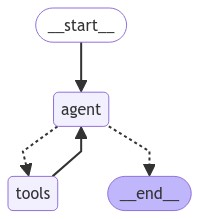

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
import duckdb


def build_db(data: dict[str, pd.DataFrame]) -> duckdb.DuckDBPyConnection:

    connection = duckdb.connect(":memory:")

    for table_name, dataframe in data.items():
        connection.register(table_name, dataframe)

    return connection

In [14]:
df = pd.read_csv("car_prices.csv")
df.loc[:, "make"] = df.loc[:, ["make"]].fillna(df["make"].mode()[0])
df.loc[:, "model"] = df.loc[:, ["model"]].fillna(df["model"].mode()[0])
df.loc[:, "body"] = df.loc[:, ["body"]].fillna(df["body"].mode()[0])
df.loc[:, "trim"] = df.loc[:, ["trim"]].fillna(df["trim"].mode()[0])
df.loc[:, "color"] = df.loc[:, ["color"]].fillna(df["color"].mode()[0])
df.loc[:, "interior"] = df.loc[:, ["interior"]].fillna(df["interior"].mode()[0])
df.loc[:, "transmission"] = df.loc[:, ["transmission"]].fillna(
    df["transmission"].mode()[0]
)

df.loc[:, "condition"] = df.loc[:, ["condition"]].fillna(df["condition"].mean())
df.loc[:, "odometer"] = df.loc[:, ["odometer"]].fillna(df["odometer"].mean())
df.loc[:, "mmr"] = df.loc[:, ["mmr"]].fillna(df["mmr"].mean())
df["saledate"] = pd.to_datetime(df["saledate"], errors="coerce", utc=True)
df.dropna(subset=["sellingprice", "saledate"], axis="rows", inplace=True)
df.info()

/var/folders/9t/0n4322_n2n3_pyh0fz_zwjzh0000gn/T/ipykernel_70929/4165688245.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["saledate"] = pd.to_datetime(df["saledate"], errors="coerce", utc=True)


<class 'pandas.core.frame.DataFrame'>
Index: 558799 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          558799 non-null  int64              
 1   make          558799 non-null  object             
 2   model         558799 non-null  object             
 3   trim          558799 non-null  object             
 4   body          558799 non-null  object             
 5   transmission  558799 non-null  object             
 6   vin           558799 non-null  object             
 7   state         558799 non-null  object             
 8   condition     558799 non-null  float64            
 9   odometer      558799 non-null  float64            
 10  color         558799 non-null  object             
 11  interior      558799 non-null  object             
 12  seller        558799 non-null  object             
 13  mmr           558799 non-null  float64           

In [15]:
config = {
    "configurable": {
        "db": build_db({"car_sales": df}),
        "recursion_limit": 25,
    }
}

In [16]:
questions = {
    1: "Which model of car had the highest growth in sales between 2015 and 2016?",
    2: "Draw a chart of sales in 2014 for the top 10 models.",
    3: "Show me the trend in Toyota sales by year. Include a chart.",
    4: (
        "Show me year on year sales movements (movement is year - prior year) from the "
        "year 2000 for toyota, include a chart. Ensure year is ordinal."
    ),
    6: "Show sales volumes by brand (vehicles not sales proce) by year.",
    7: "Examine sales trends from 2000 to 2005, do all brands have the same trend?",
    8: "Examine sales trends from 2000 to 2005, do all brands have the same trend? Consider multiple sql statements.",
    9: "Are car sales seasonal? Does this vary by year or state?",
}

input = prompt_template.invoke({"question": questions[8]})

for event in graph.stream(input, config=config):
    value = next(iter(event.values()))
    print(value["messages"][0].pretty_print())

================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_uWp1GgyvmzuYTeU5wvuSiDYl)
 Call ID: call_uWp1GgyvmzuYTeU5wvuSiDYl
  Args:
None
================================= Tool Message =================================
Name: sql_db_list_tables

car_sales
None
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_h000bcTjP2GrADeBxjcAg4YH)
 Call ID: call_h000bcTjP2GrADeBxjcAg4YH
  Args:
    table_names: car_sales
None
================================= Tool Message =================================
Name: sql_db_schema



TABLE:car_sales

 column_name              column_type null  key default extra
        year                   BIGINT  YES None    None  None
        make                  VARCHAR  YES None    None  None
       model                  VARCHAR  YES None    None  None
        trim                  VARCHAR  YES None    None  None
        body               